# 1. Import and Install Dependencies


In [123]:
import cv2
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from itertools import cycle

# 2. Keypoints using MP Holistic


In [124]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_face_mesh = mp.solutions.face_mesh

In [125]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [126]:
def draw_landmarks(image, results):
    # Draw face mesh
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.face_landmarks, 
            mp_face_mesh.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )
    
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.pose_landmarks, 
            mp_holistic.POSE_CONNECTIONS
        )
    
    # Draw hands
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.left_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS
        )
    
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.right_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS
        )

In [127]:
def draw_styled_landmarks(image, results):
    # Draw face connections with error checking
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.face_landmarks, 
            mp_face_mesh.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )
    
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.pose_landmarks, 
            mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )
    
    # Draw hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.left_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.right_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS, 
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )


In [128]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1744785880.213021   10465 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744785880.216073  184992 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.3-arch1.1), renderer: AMD Radeon 680M (radeonsi, rembrandt, LLVM 19.1.7, DRM 3.61, 6.14.2-arch1-1)
W0000 00:00:1744785880.280520  184975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744785880.320647  184974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744785880.323369  184975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744785880.323467  184983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [129]:
draw_landmarks(frame, results)

In [130]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values


In [131]:
# Check if face landmarks are available before trying to access them
if results.face_landmarks:
	print(f"Number of face landmarks detected: {len(results.face_landmarks.landmark)}")
else:
	print("No face landmarks detected in the current frame")

Number of face landmarks detected: 468


In [132]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [133]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [134]:
face = (np.array([[res.x, res.y, res.z] 
                  for res in results.face_landmarks.landmark]).flatten() 
        if results.face_landmarks 
        else np.zeros(1404))


In [135]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [136]:
result_test = extract_keypoints(results)

In [137]:
result_test

array([ 0.51437938,  0.50506818, -0.58498442, ...,  0.        ,
        0.        ,  0.        ])

In [138]:
# np.save('0', result_test)

In [139]:
# np.load('0.npy')

# 4. Setup Folders for Collection


In [140]:
# Define paths and actions
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['Hello', 'Hill', 'Deaf', 'Thanks', 'You'])
no_sequences = 30
sequence_length = 30

# 5. Collect Keypoint Values for Training and Testing


In [141]:
# Function to check if data exists
def check_existing_data(data_path, action, sequence_length):
    missing_sequences = []
    action_path = os.path.join(data_path, action)
    for sequence in range(no_sequences):
        sequence_path = os.path.join(action_path, str(sequence))
        # Check if all frames for this sequence exist
        if not os.path.exists(sequence_path) or \
           len(os.listdir(sequence_path)) < sequence_length:
            missing_sequences.append(sequence)
    return missing_sequences

# Function to collect data
def capture_data(actions, sequence_length, no_sequences):
    cap = cv2.VideoCapture(0)
    with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for action in actions:
            print(f"Processing action: {action}")
            
            # Check missing sequences
            missing_sequences = check_existing_data(DATA_PATH, action, sequence_length)
            if not missing_sequences:
                print(f"All data for '{action}' is already collected. Skipping.")
                continue
            
            for sequence in missing_sequences:
                print(f"Collecting data for action '{action}', sequence {sequence}")
                for frame_num in range(sequence_length):
                    ret, frame = cap.read()
                    image, results = mediapipe_detection(frame, holistic)
                    draw_styled_landmarks(image, results)

                    # Display progress
                    if frame_num == 0:
                        cv2.putText(image, f'STARTING COLLECTION for {action} (Seq: {sequence})', (15, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(500)
                    else:
                        cv2.putText(image, f'Collecting frames for {action} (Seq: {sequence})', (15, 50),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

                    # Extract and save keypoints
                    keypoints = extract_keypoints(results)
                    sequence_path = os.path.join(DATA_PATH, action, str(sequence))
                    os.makedirs(sequence_path, exist_ok=True)
                    np.save(os.path.join(sequence_path, str(frame_num)), keypoints)

                    # Display image
                    cv2.imshow('OpenCV Feed', image)

                    # Exit on 'q'
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        return

        cap.release()
        cv2.destroyAllWindows()


In [142]:
capture_data(actions, sequence_length, no_sequences)

I0000 00:00:1744785893.794310   10465 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744785893.796363  185243 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.3-arch1.1), renderer: AMD Radeon 680M (radeonsi, rembrandt, LLVM 19.1.7, DRM 3.61, 6.14.2-arch1-1)
W0000 00:00:1744785893.841001  185226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744785893.877299  185239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744785893.879783  185237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744785893.879858  185232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

Processing action: Hello
Processing action: Hill
All data for 'Hill' is already collected. Skipping.
Processing action: Deaf
All data for 'Deaf' is already collected. Skipping.
Processing action: Thanks
All data for 'Thanks' is already collected. Skipping.
Processing action: You
All data for 'You' is already collected. Skipping.
Processing action: Hill
All data for 'Hill' is already collected. Skipping.
Processing action: Deaf
All data for 'Deaf' is already collected. Skipping.
Processing action: Thanks
All data for 'Thanks' is already collected. Skipping.
Processing action: You
All data for 'You' is already collected. Skipping.


# 6. Preprocess Data and Create Labels and Features


In [143]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [144]:
label_map = {label:num for num, label in enumerate(actions)}

In [145]:
label_map

{'Hello': 0, 'Hill': 1, 'Deaf': 2, 'Thanks': 3, 'You': 4}

In [146]:
def load_gesture_data(DATA_PATH, actions, sequence_length):
    sequences, labels = [], []
    
    for action in actions:
        action_path = os.path.join(DATA_PATH, action)
        if not os.path.exists(action_path):
            print(f"Warning: Path {action_path} does not exist")
            continue
            
        # Get valid sequence folders and sort them
        sequence_folders = [f for f in os.listdir(action_path) 
                          if os.path.isdir(os.path.join(action_path, f))]
        sequence_numbers = sorted([int(seq) for seq in sequence_folders])
        
        for sequence in sequence_numbers:
            try:
                window = []
                sequence_path = os.path.join(action_path, str(sequence))
                
                # Check if all frame files exist
                frames_exist = all(os.path.exists(os.path.join(sequence_path, f"{frame_num}.npy")) 
                                 for frame_num in range(sequence_length))
                
                if not frames_exist:
                    print(f"Skipping incomplete sequence: {sequence_path}")
                    continue
                    
                # Load frame data
                for frame_num in range(sequence_length):
                    frame_path = os.path.join(sequence_path, f"{frame_num}.npy")
                    res = np.load(frame_path)
                    window.append(res)
                    
                sequences.append(window)
                labels.append(label_map[action])
                
            except Exception as e:
                print(f"Error processing sequence {sequence} for action {action}: {e}")
                continue
                
    return np.array(sequences), np.array(labels)

# Load the data
sequences, labels = load_gesture_data(DATA_PATH, actions, sequence_length)
print(f"Loaded {len(sequences)} sequences")

Loaded 150 sequences


In [147]:
np.array(sequences).shape

(150, 30, 1662)

In [148]:
np.array(labels).shape

(150,)

In [149]:
X = np.array(sequences)

In [150]:
X.shape

(150, 30, 1662)

In [151]:
y = to_categorical(labels).astype(int)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [153]:
y_test.shape

(8, 5)

# 7. Build and Train Multiple LSTM Neural Network Models

We'll implement and compare 5 different model architectures with various regularization techniques to improve performance and reduce overfitting.

In [154]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional, GRU
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from itertools import cycle

In [155]:
# Create logs directory if it doesn't exist
log_dir = os.path.join('Logs')
os.makedirs(log_dir, exist_ok=True)

# Create models directory if it doesn't exist
models_dir = os.path.join('Models')
os.makedirs(models_dir, exist_ok=True)

In [156]:
# Disable GPU usage for this notebook to avoid CUDA errors
tf.config.set_visible_devices([], 'GPU')

In [157]:
# Define callback functions for all models
def get_callbacks(model_name):
    return [
        # TensorBoard logging
        TensorBoard(log_dir=os.path.join(log_dir, model_name)),
        
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Save the best model during training
        ModelCheckpoint(
            filepath=os.path.join(models_dir, f'{model_name}.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        
        # Reduce learning rate when model plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.00001,
            verbose=1
        )
    ]

In [158]:
# Model 0: Basic LSTM (No regularization or additional features)
def create_model_0(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape),
        LSTM(64, return_sequences=False, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [159]:
# Model 1: Basic LSTM with Dropout
def create_model_1(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape, 
             dropout=0.2, recurrent_dropout=0.2),
        LSTM(64, return_sequences=True, activation='relu', dropout=0.2),
        LSTM(64, return_sequences=False, activation='relu', dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'), 
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [160]:
# Model 2: Bidirectional LSTM with BatchNormalization
def create_model_2(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, activation='relu'), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True, activation='relu')),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=False, activation='relu')),
        BatchNormalization(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [161]:
# Model 3: GRU with L2 Regularization
def create_model_3(input_shape, num_classes):
    model = Sequential([
        GRU(128, return_sequences=True, activation='relu', input_shape=input_shape,
            kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
        Dropout(0.3),
        GRU(128, return_sequences=True, activation='relu',
            kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
        Dropout(0.3),
        GRU(64, return_sequences=False, activation='relu',
            kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [162]:
# Model 4: LSTM with Residual Connections
def create_model_4(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer
    x = LSTM(64, return_sequences=True, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    # Second LSTM layer with residual connection
    lstm_out = LSTM(64, return_sequences=True, activation='relu')(x)
    x = Dropout(0.3)(lstm_out)
    x = BatchNormalization()(x)
    # Add residual connection
    x = tf.keras.layers.add([x, lstm_out])
    
    # Third LSTM layer
    x = LSTM(64, return_sequences=False, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


In [163]:
# Model 5: Hybrid LSTM-GRU Model
def create_model_5(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        GRU(128, return_sequences=True, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64, return_sequences=False, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [164]:
# Dictionary to store model histories for comparison
model_histories = {}
model_accuracies = {}
model_val_accuracies = {}
model_training_times = {}
model_predictions = {}  # Store predictions for later metric calculations
model_probabilities = {}  # Store prediction probabilities for ROC curves

# Function to train models and store results
def train_and_evaluate_model(model_creator, model_name, input_shape, num_classes, X_train, y_train, X_test, y_test):
    print(f"\n============ Training {model_name} ============")
    model = model_creator(input_shape, num_classes)
    model.summary()
    
    # Get callbacks for this model
    callbacks = get_callbacks(model_name)
    
    # Train the model with validation split for early stopping
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=32,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )
    end_time = time.time()
    
    # Get predictions and probabilities for metrics calculation
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Store predictions and probabilities
    model_predictions[model_name] = (y_true, y_pred)
    model_probabilities[model_name] = (y_test, y_pred_proba)
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} - Test accuracy: {test_acc:.4f}")
    
    # Store results
    model_histories[model_name] = history
    model_accuracies[model_name] = history.history['categorical_accuracy']
    model_val_accuracies[model_name] = history.history['val_categorical_accuracy']
    model_training_times[model_name] = end_time - start_time
    
    # Save the model
    model.save(os.path.join(models_dir, f'{model_name}_final.keras'))
    
    return model, history, test_acc

In [165]:
# Define input shape and number of classes
input_shape = (30, 1662)  # 30 frames, 1662 features per frame
num_classes = len(actions)

# Train all models
models = {
    'Basic_LSTM': create_model_0,  
    'LSTM_Dropout': create_model_1,
    'BiLSTM_BatchNorm': create_model_2,
    'GRU_L2Reg': create_model_3,
    'LSTM_Residual': create_model_4,
    'Hybrid_LSTM_GRU': create_model_5
}

# Store test accuracies for comparison
test_accuracies = {}

In [166]:
# Train each model separately
for model_name, model_creator in models.items():
    model, history, test_acc = train_and_evaluate_model(
        model_creator, model_name, input_shape, num_classes, X_train, y_train, X_test, y_test
    )
    test_accuracies[model_name] = test_acc


============ Training Basic_LSTM ============


/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,381 (1.82 MB)

 Trainable params: 477,381 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - categorical_accuracy: 0.1586 - loss: 2.5823
Epoch 1: val_loss improved from inf to 3.27897, saving model to Models/Basic_LSTM.keras

Epoch 1: val_loss improved from inf to 3.27897, saving model to Models/Basic_LSTM.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 526ms/step - categorical_accuracy: 0.1631 - loss: 2.7567 - val_categorical_accuracy: 0.0667 - val_loss: 3.2790 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 526ms/step - categorical_accuracy: 0.1631 - loss: 2.7567 - val_categorical_accuracy: 0.0667 - val_loss: 3.2790 - learning_rate: 0.0010
Epoch 2/150
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.2326 - loss: 2.3867
Epoch 2: val_loss improved from 3.27897 to 1.92671, saving model to Models/Basic_LSTM.keras

Epoch 2: val_loss improved from 3.27897 to 1.92671, saving model to Models/Basic_LSTM.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_accuracy: 0.2215 - loss: 2.4211 - val_categorical_accur

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 30, 128)        │       916,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,005,829 (3.84 MB)

 Trainable params: 1,005,829 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - categorical_accuracy: 0.2759 - loss: 5.6802
Epoch 1: val_loss improved from inf to 7.09800, saving model to Models/LSTM_Dropout.keras

Epoch 1: val_loss improved from inf to 7.09800, saving model to Models/LSTM_Dropout.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - categorical_accuracy: 0.2727 - loss: 6.2673 - val_categorical_accuracy: 0.0667 - val_loss: 7.0980 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - categorical_accuracy: 0.2727 - loss: 6.2673 - val_categorical_accuracy: 0.0667 - val_loss: 7.0980 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - categorical_accuracy: 0.2785 - loss: 30.2985
Epoch 2: val_loss improved from 7.09800 to 5.33611, saving model to Models/LSTM_Dropout.keras

Epoch 2: val_loss improved from 7.09800 to 5.33611, saving model to Models/LSTM_Dropout.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - categorical_accuracy: 0.2779 - loss: 32.6849 - val_categorica

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 30, 128)        │       884,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 30, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,324,293 (5.05 MB)

 Trainable params: 1,323,269 (5.05 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2310 - loss: 2.1566   
Epoch 1: val_loss improved from inf to 13.71181, saving model to Models/BiLSTM_BatchNorm.keras

Epoch 1: val_loss improved from inf to 13.71181, saving model to Models/BiLSTM_BatchNorm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - categorical_accuracy: 0.2352 - loss: 2.1406 - val_categorical_accuracy: 0.2000 - val_loss: 13.7118 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - categorical_accuracy: 0.2352 - loss: 2.1406 - val_categorical_accuracy: 0.2000 - val_loss: 13.7118 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_accuracy: 0.2375 - loss: 1.9449
Epoch 2: val_loss improved from 13.71181 to 11.14277, saving model to Models/BiLSTM_BatchNorm.keras

Epoch 2: val_loss improved from 13.71181 to 11.14277, saving model to Models/BiLSTM_BatchNorm.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - categorical_accuracy: 0.2404 - loss: 

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 30, 128)        │       688,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 30, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,853 (3.17 MB)

 Trainable params: 830,853 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - categorical_accuracy: 0.2009 - loss: 2.9944
Epoch 1: val_loss improved from inf to 2.89000, saving model to Models/GRU_L2Reg.keras

Epoch 1: val_loss improved from inf to 2.89000, saving model to Models/GRU_L2Reg.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 867ms/step - categorical_accuracy: 0.1953 - loss: 2.9935 - val_categorical_accuracy: 0.3333 - val_loss: 2.8900 - learning_rate: 5.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 867ms/step - categorical_accuracy: 0.1953 - loss: 2.9935 - val_categorical_accuracy: 0.3333 - val_loss: 2.8900 - learning_rate: 5.0000e-04
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.1931 - loss: 2.9296
Epoch 2: val_loss improved from 2.89000 to 2.81106, saving model to Models/GRU_L2Reg.keras

Epoch 2: val_loss improved from 2.89000 to 2.81106, saving model to Models/GRU_L2Reg.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - categorical_accuracy: 0.1923 - loss: 2.9249 - val_categorical_

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 30, 1662)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ (None, 30, 64)    │    442,112 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 30, 64)    │          0 │ lstm_34[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ dropout_40[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 30, 64)    │     33,024 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 30, 64)    │          0 │ lstm_35[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ dropout_41[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_35[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 64)        │     33,024 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 64)        │          0 │ lstm_36[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_42[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 64)        │          0 │ dense_47[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 32)        │      2,080 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 5)         │        165 │ dense_48[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 515,333 (1.97 MB)

 Trainable params: 514,949 (1.96 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - categorical_accuracy: 0.2530 - loss: 1.8989
Epoch 1: val_loss improved from inf to 24.83579, saving model to Models/LSTM_Residual.keras

Epoch 1: val_loss improved from inf to 24.83579, saving model to Models/LSTM_Residual.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 932ms/step - categorical_accuracy: 0.2465 - loss: 1.9070 - val_categorical_accuracy: 0.1333 - val_loss: 24.8358 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 932ms/step - categorical_accuracy: 0.2465 - loss: 1.9070 - val_categorical_accuracy: 0.1333 - val_loss: 24.8358 - learning_rate: 0.0010
Epoch 2/150
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.1597 - loss: 2.0758
Epoch 2: val_loss improved from 24.83579 to 20.32323, saving model to Models/LSTM_Residual.keras

Epoch 2: val_loss improved from 24.83579 to 20.32323, saving model to Models/LSTM_Residual.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.1746 - loss: 2.0341 - v

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                  │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 30, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,861 (2.23 MB)

 Trainable params: 585,349 (2.23 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - categorical_accuracy: 0.2348 - loss: 1.8405
Epoch 1: val_loss improved from inf to 1.71873, saving model to Models/Hybrid_LSTM_GRU.keras

Epoch 1: val_loss improved from inf to 1.71873, saving model to Models/Hybrid_LSTM_GRU.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step - categorical_accuracy: 0.2351 - loss: 1.8395 - val_categorical_accuracy: 0.3333 - val_loss: 1.7187 - learning_rate: 0.0010
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step - categorical_accuracy: 0.2351 - loss: 1.8395 - val_categorical_accuracy: 0.3333 - val_loss: 1.7187 - learning_rate: 0.0010
Epoch 2/150
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.2083 - loss: 1.8539
Epoch 2: val_loss did not improve from 1.71873
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.2226 - loss: 1.8336 - val_categorical_accuracy: 0.2000 - val_loss: 1.9568 - learning_rate: 0.0010
Epoch 3/150

Epoch 2: val_loss did not improve from 1.71873
4/4 ━━━━━━━━━

# Advanced Model Evaluation

Let's evaluate our models using confusion matrices, ROC curves, and F1 scores.

In [167]:
def plot_confusion_matrix(model_name, y_true, y_pred):
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get unique classes in the actual and predicted labels
    unique_classes = sorted(set(np.concatenate((y_true, y_pred))))
    
    # Create display labels for the classes
    class_labels = [actions[i] for i in unique_classes]
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print classification report with explicit label parameter
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, labels=unique_classes, 
                              target_names=class_labels, zero_division=0))

In [168]:
def plot_roc_curves(model_name, y_test, y_score):
    # Compute ROC curve and ROC area for each class
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown'])
    
    for i, color, action in zip(range(n_classes), colors, actions):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{action} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [169]:
def calculate_f1_scores():
    f1_scores = {}
    f1_scores_weighted = {}
    f1_scores_macro = {}
    
    for model_name, (y_true, y_pred) in model_predictions.items():
        # Calculate per-class F1 scores
        f1 = f1_score(y_true, y_pred, average=None)
        f1_scores[model_name] = dict(zip(actions, f1))
        
        # Calculate weighted and macro F1 scores
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_scores_weighted[model_name] = f1_weighted
        f1_scores_macro[model_name] = f1_macro
    
    return f1_scores, f1_scores_weighted, f1_scores_macro

In [170]:
def plot_f1_scores(f1_scores, f1_scores_weighted):
    # Plot per-class F1 scores for each model
    plt.figure(figsize=(14, 8))
    
    # Create a DataFrame for easy plotting
    f1_data = []
    for model_name, class_scores in f1_scores.items():
        for action, score in class_scores.items():
            f1_data.append({'Model': model_name, 'Action': action, 'F1 Score': score})
    
    f1_df = pd.DataFrame(f1_data)
    
    # Plot grouped bar chart
    sns.barplot(x='Model', y='F1 Score', hue='Action', data=f1_df)
    plt.title('F1 Score by Model and Class')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.legend(title='Action')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot weighted F1 scores
    plt.figure(figsize=(12, 6))
    models = list(f1_scores_weighted.keys())
    scores = list(f1_scores_weighted.values())
    
    # Sort models by F1 score
    sort_idx = np.argsort(scores)
    sorted_models = [models[i] for i in sort_idx[::-1]]
    sorted_scores = [scores[i] for i in sort_idx[::-1]]
    
    bars = plt.bar(sorted_models, sorted_scores, color='skyblue')
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.4f}', ha='center', va='bottom')
    
    plt.title('Weighted F1 Score by Model')
    plt.xlabel('Model')
    plt.ylabel('Weighted F1 Score')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [171]:
# Calculate all metrics and update performance data
f1_scores, f1_scores_weighted, f1_scores_macro = calculate_f1_scores()

# Create performance data structure
performance_data = []
for model_name, test_acc in test_accuracies.items():
    # Calculate overfitting as difference between best validation accuracy and last training accuracy
    history = model_histories[model_name]
    train_acc = history.history['categorical_accuracy'][-1]
    val_acc = max(history.history['val_categorical_accuracy']) if 'val_categorical_accuracy' in history.history else train_acc
    overfitting = train_acc - val_acc
    
    # Create performance record
    performance_data.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Training Accuracy': train_acc,
        'Best Val Accuracy': val_acc,
        'Overfitting': overfitting,
        'Training Time (s)': model_training_times[model_name],
        'F1 Score (Weighted)': 0.0,  # Will be updated below
        'F1 Score (Macro)': 0.0      # Will be updated below
    })

# Update performance data with F1 scores
for i, data in enumerate(performance_data):
    model_name = data['Model']
    if model_name in f1_scores_weighted:
        performance_data[i]['F1 Score (Weighted)'] = f1_scores_weighted[model_name]
        performance_data[i]['F1 Score (Macro)'] = f1_scores_macro[model_name]

# Create updated DataFrame
updated_performance_df = pd.DataFrame(performance_data)
updated_performance_df = updated_performance_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
updated_performance_df

,Model,Test Accuracy,Training Accuracy,Best Val Accuracy,Overfitting,Training Time (s),F1 Score (Weighted),F1 Score (Macro)
0,Basic_LSTM,0.750,0.685039,1.000000,-0.314961,20.453587,0.741667,0.738889
1,GRU_L2Reg,0.625,0.921260,0.866667,0.054593,37.455130,0.575000,0.516667
2,BiLSTM_BatchNorm,0.375,0.937008,0.733333,0.203674,49.483115,0.291667,0.277778
3,LSTM_Residual,0.250,0.692913,0.466667,0.226247,18.128187,0.196429,0.261905
4,LSTM_Dropout,0.125,0.157480,0.533333,-0.375853,18.198461,0.100000,0.100000
5,Hybrid_LSTM_GRU,0.000,0.590551,0.533333,0.057218,16.233602,0.000000,0.000000


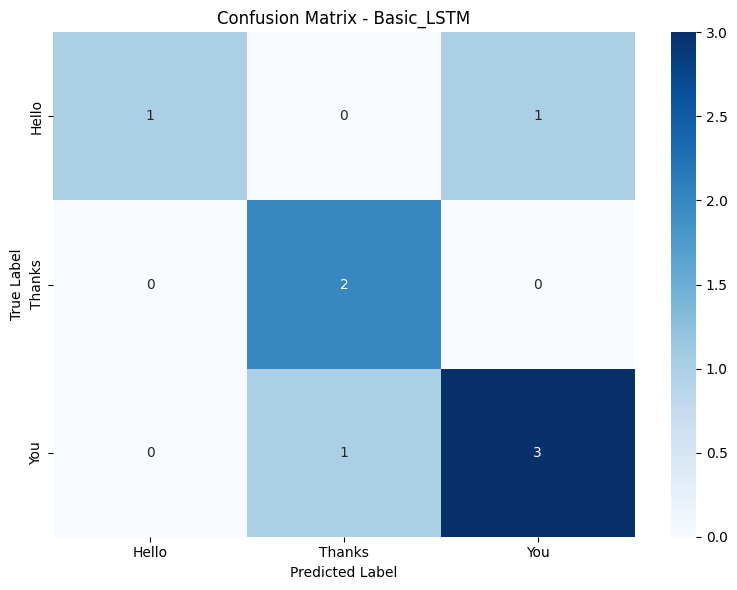


Classification Report for Basic_LSTM:
              precision    recall  f1-score   support

       Hello       1.00      0.50      0.67         2
      Thanks       0.67      1.00      0.80         2
         You       0.75      0.75      0.75         4

    accuracy                           0.75         8
   macro avg       0.81      0.75      0.74         8
weighted avg       0.79      0.75      0.74         8



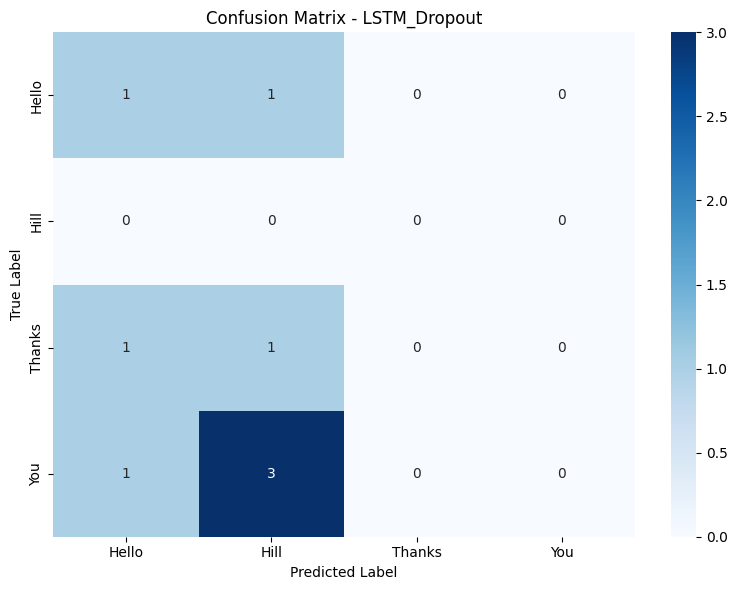


Classification Report for LSTM_Dropout:
              precision    recall  f1-score   support

       Hello       0.33      0.50      0.40         2
        Hill       0.00      0.00      0.00         0
      Thanks       0.00      0.00      0.00         2
         You       0.00      0.00      0.00         4

    accuracy                           0.12         8
   macro avg       0.08      0.12      0.10         8
weighted avg       0.08      0.12      0.10         8



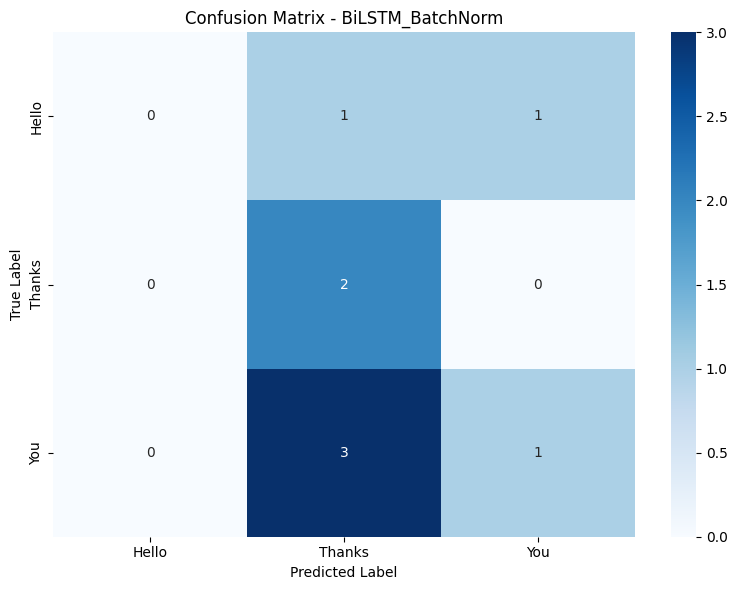


Classification Report for BiLSTM_BatchNorm:
              precision    recall  f1-score   support

       Hello       0.00      0.00      0.00         2
      Thanks       0.33      1.00      0.50         2
         You       0.50      0.25      0.33         4

    accuracy                           0.38         8
   macro avg       0.28      0.42      0.28         8
weighted avg       0.33      0.38      0.29         8



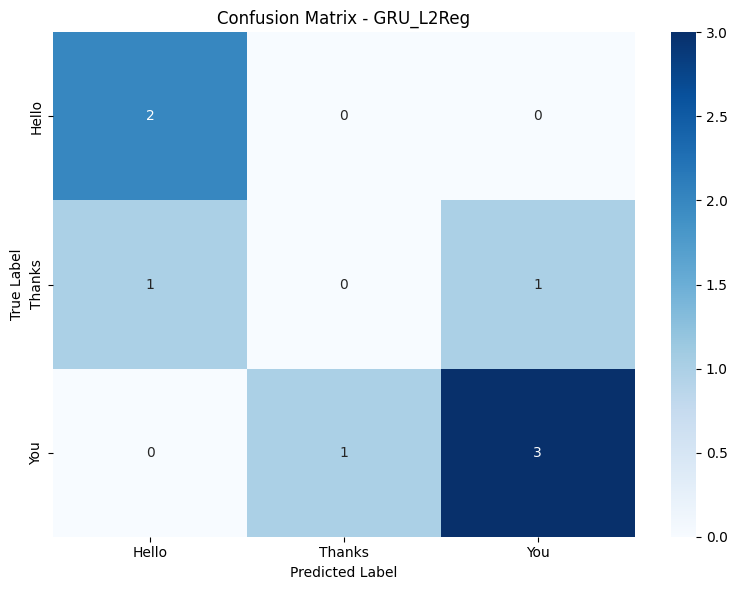


Classification Report for GRU_L2Reg:
              precision    recall  f1-score   support

       Hello       0.67      1.00      0.80         2
      Thanks       0.00      0.00      0.00         2
         You       0.75      0.75      0.75         4

    accuracy                           0.62         8
   macro avg       0.47      0.58      0.52         8
weighted avg       0.54      0.62      0.57         8



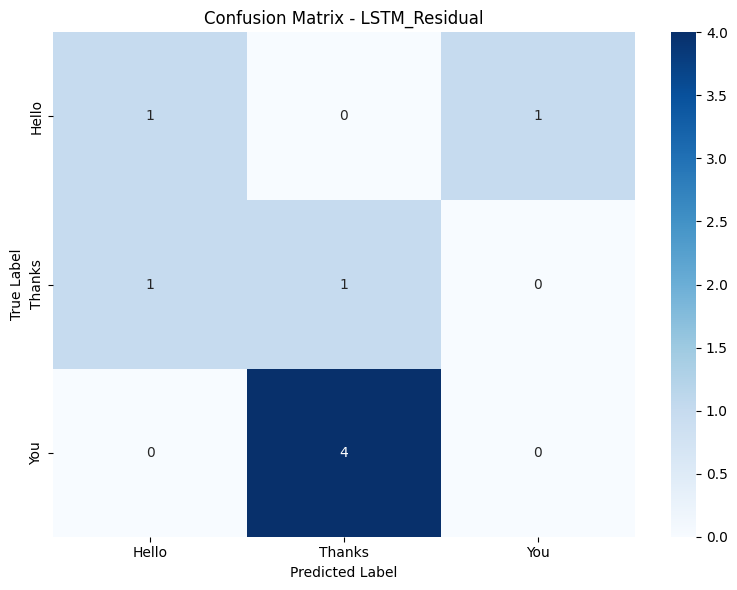


Classification Report for LSTM_Residual:
              precision    recall  f1-score   support

       Hello       0.50      0.50      0.50         2
      Thanks       0.20      0.50      0.29         2
         You       0.00      0.00      0.00         4

    accuracy                           0.25         8
   macro avg       0.23      0.33      0.26         8
weighted avg       0.17      0.25      0.20         8



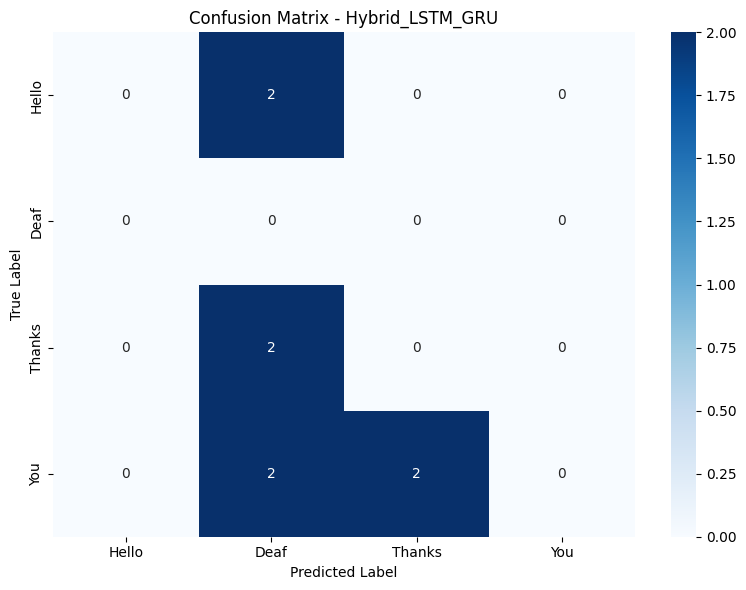


Classification Report for Hybrid_LSTM_GRU:
              precision    recall  f1-score   support

       Hello       0.00      0.00      0.00       2.0
        Deaf       0.00      0.00      0.00       0.0
      Thanks       0.00      0.00      0.00       2.0
         You       0.00      0.00      0.00       4.0

    accuracy                           0.00       8.0
   macro avg       0.00      0.00      0.00       8.0
weighted avg       0.00      0.00      0.00       8.0



In [172]:
# Plot confusion matrices for all models
for model_name, (y_true, y_pred) in model_predictions.items():
    try:
        plot_confusion_matrix(model_name, y_true, y_pred)
    except Exception as e:
        print(f"Error plotting confusion matrix for {model_name}: {e}")
        print(f"Unique values in y_true: {np.unique(y_true)}")
        print(f"Unique values in y_pred: {np.unique(y_pred)}")
        print(f"Actions array: {actions}")

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


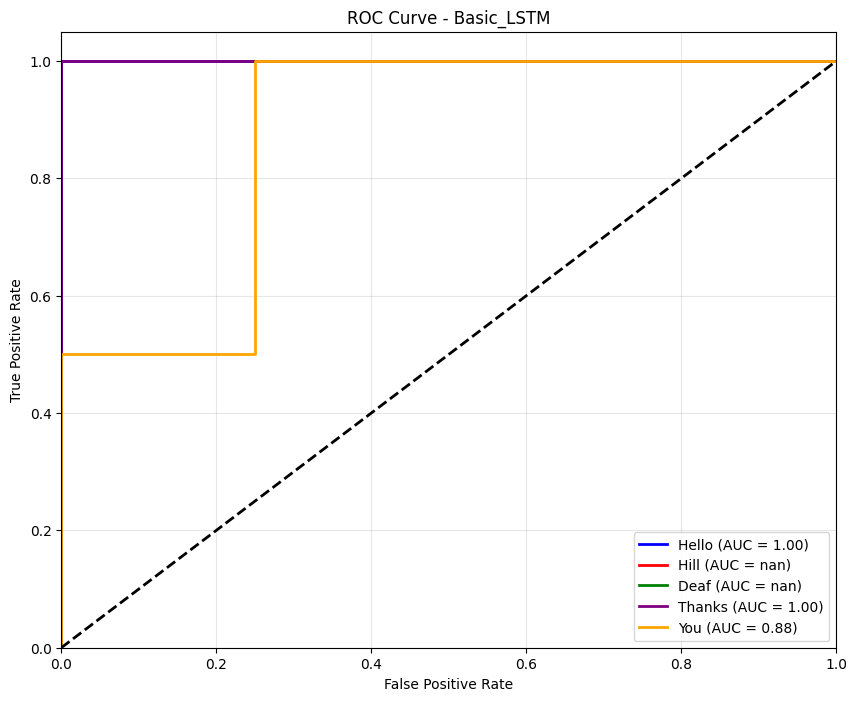

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


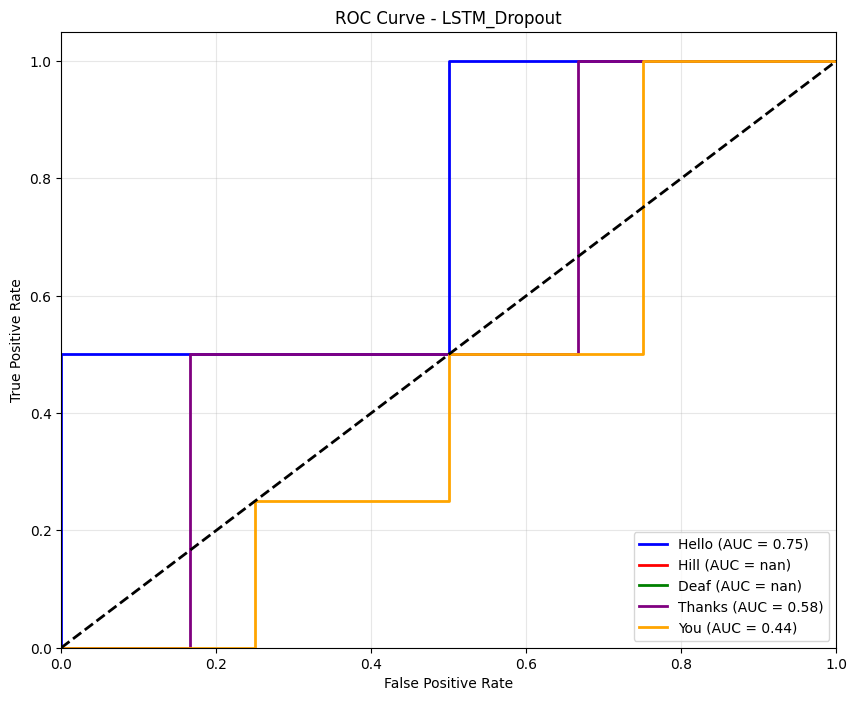

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


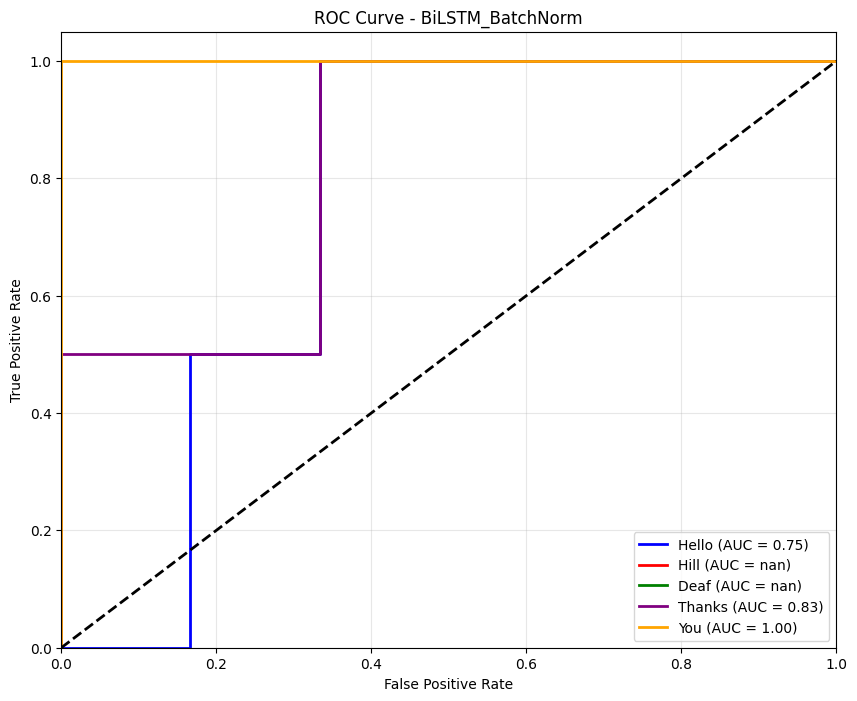

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


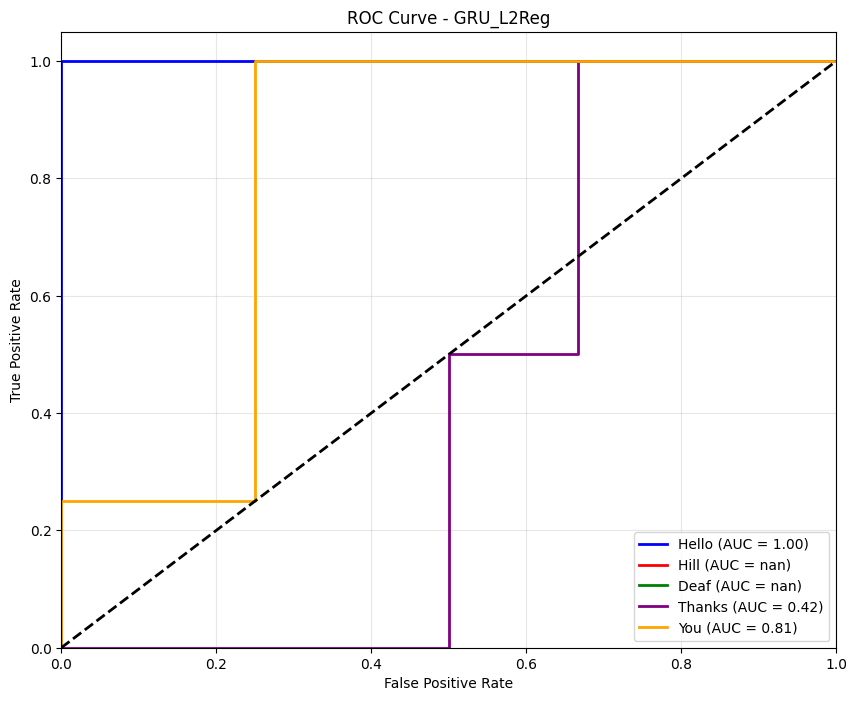

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


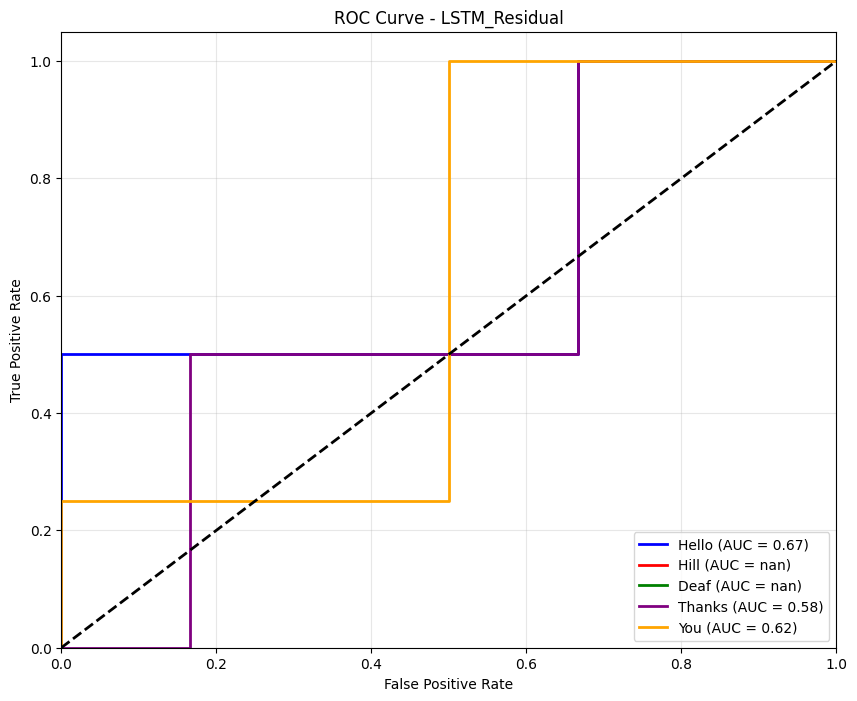

/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/strix/miniforge3/envs/epics/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


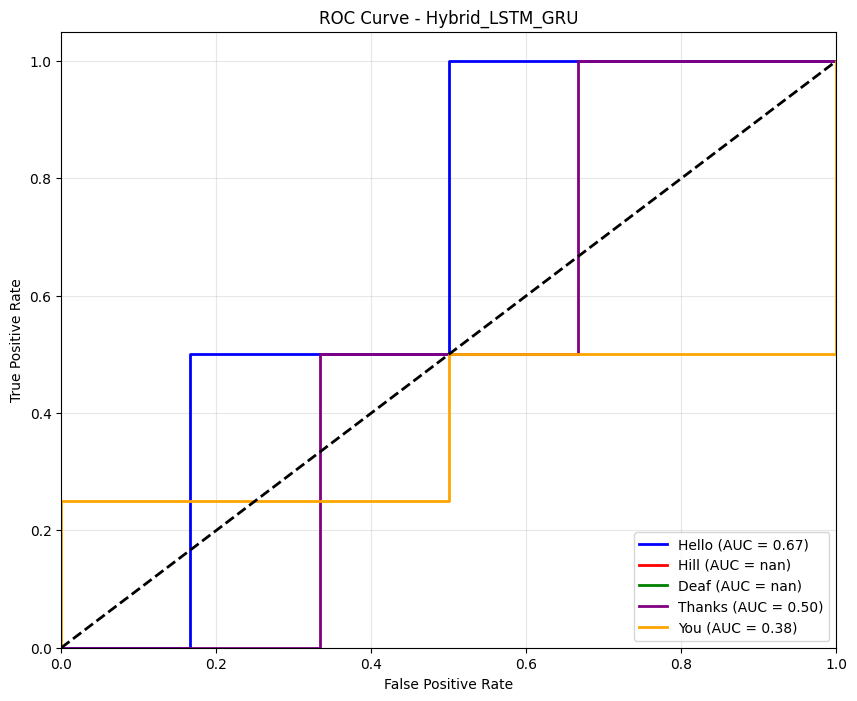

In [173]:
# Plot ROC curves for all models
for model_name, (y_test, y_pred_proba) in model_probabilities.items():
    plot_roc_curves(model_name, y_test, y_pred_proba)

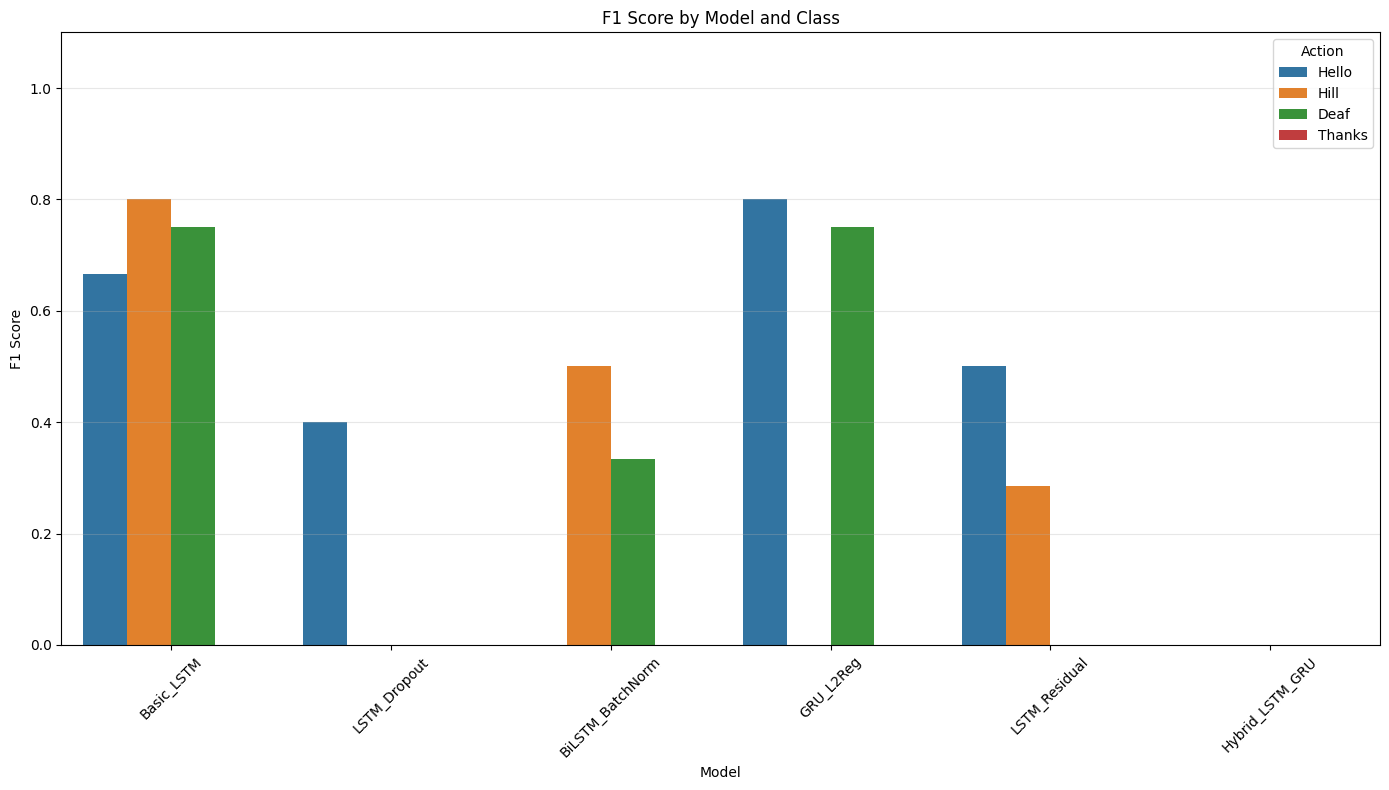

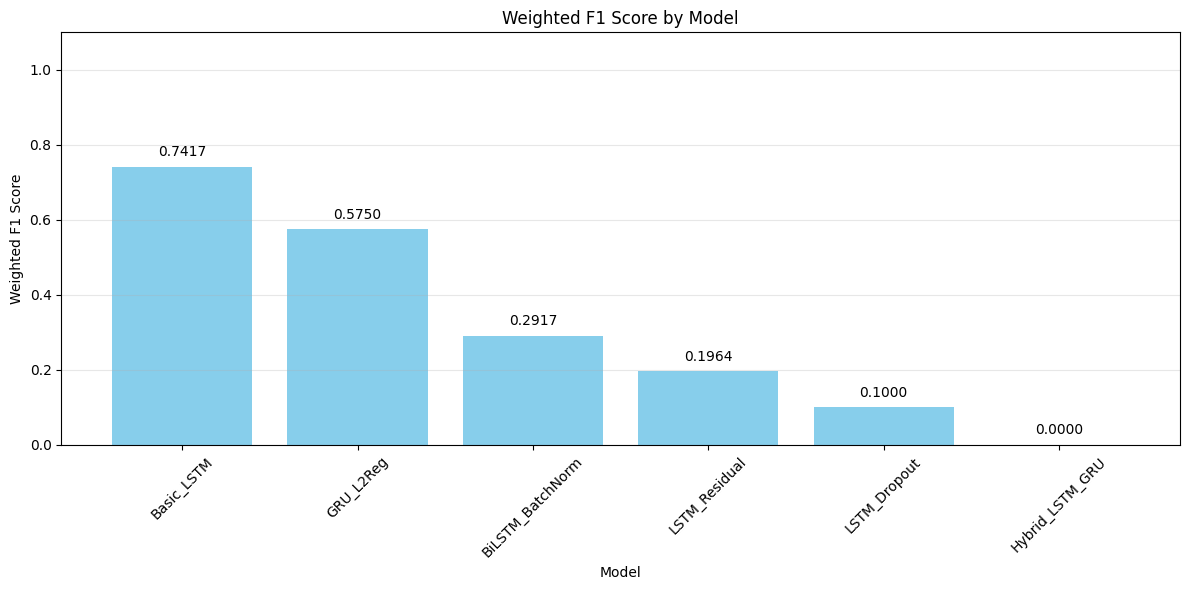

In [174]:
# Plot F1 scores
plot_f1_scores(f1_scores, f1_scores_weighted)

# Model Selection Based on Multiple Metrics

Now we can select the best model based on multiple metrics: accuracy, F1 score, and ROC AUC.

In [175]:
# Find the best model based on multiple metrics
def ranking_models(performance_df):
    # Create a copy to avoid modifying the original DataFrame
    df = performance_df.copy()
    
    # Normalize the training time (lower is better)
    max_time = df['Training Time (s)'].max()
    df['Time Score'] = 1 - (df['Training Time (s)'] / max_time)
    
    # Overfitting penalty (closer to 0 is better)
    df['Overfitting Score'] = 1 - abs(df['Overfitting'])
    
    # Calculate a composite score (you can adjust weights as needed)
    df['Composite Score'] = (
        0.40 * df['Test Accuracy'] +  # Test accuracy weight
        0.30 * df['F1 Score (Weighted)'] +  # F1 score weight
        0.15 * df['Overfitting Score'] +  # Overfitting weight
        0.15 * df['Time Score']  # Training time weight
    )
    
    # Sort by composite score
    return df.sort_values('Composite Score', ascending=False).reset_index(drop=True)

# Get ranked models
ranked_models = ranking_models(updated_performance_df)
ranked_models[['Model', 'Test Accuracy', 'F1 Score (Weighted)', 'Overfitting', 'Training Time (s)', 'Composite Score']]

,Model,Test Accuracy,F1 Score (Weighted),Overfitting,Training Time (s),Composite Score
0,Basic_LSTM,0.750,0.741667,-0.314961,20.453587,0.713254
1,GRU_L2Reg,0.625,0.575000,0.054593,37.455130,0.600772
2,LSTM_Residual,0.250,0.196429,0.226247,18.128187,0.370039
3,BiLSTM_BatchNorm,0.375,0.291667,0.203674,49.483115,0.356949
4,LSTM_Dropout,0.125,0.100000,-0.375853,18.198461,0.268456
5,Hybrid_LSTM_GRU,0.000,0.000000,0.057218,16.233602,0.242208


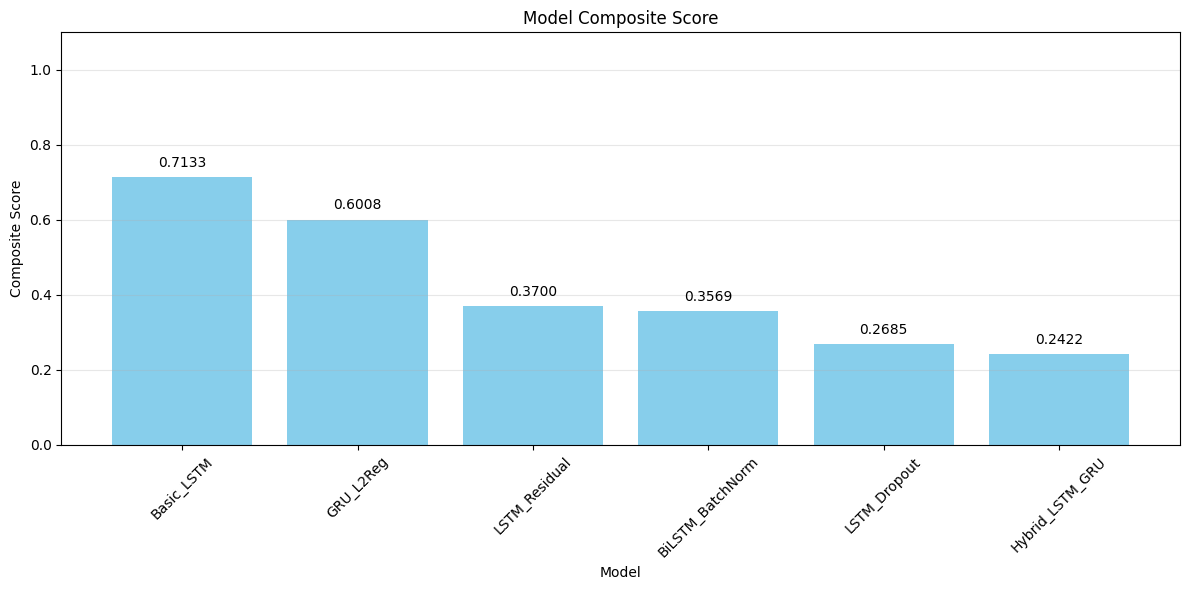

In [176]:
# Visualize the composite score
plt.figure(figsize=(12, 6))
bars = plt.bar(ranked_models['Model'], ranked_models['Composite Score'], color='skyblue')

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Composite Score')
plt.xlabel('Model')
plt.ylabel('Composite Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [177]:
best_overall_model_name = ranked_models.iloc[0]['Model']
print(f"Best overall model based on multiple metrics: {best_overall_model_name}")

# Load the best overall model
best_overall_model_path = os.path.join(models_dir, f'{best_overall_model_name}.keras')
best_overall_model = tf.keras.models.load_model(best_overall_model_path)

# Save it with a descriptive name
best_overall_model.save('best_sign_language_model_composite.keras')
print(f"Best overall model saved as 'best_sign_language_model_composite.keras'")

Best overall model based on multiple metrics: Basic_LSTM
Best overall model saved as 'best_sign_language_model_composite.keras'


# 9. Save Best Model

Let's save the best performing model for future use.

In [178]:
# Get the best model based on test accuracy
best_model_name = updated_performance_df.iloc[0]['Model']
print(f"Best model based on test accuracy: {best_model_name}")

# Load the best model (the one saved during training)
best_model_path = os.path.join(models_dir, f'{best_model_name}.keras')
best_model = tf.keras.models.load_model(best_model_path)

# Save it with a descriptive name
best_model.save('best_sign_language_model.keras')
print(f"Best model saved as 'best_sign_language_model.keras'")

Best model based on test accuracy: Basic_LSTM
Best model saved as 'best_sign_language_model.keras'
Best model saved as 'best_sign_language_model.keras'


# 11. Test Best Model in Real Time

Let's test our best model in a real-time setting.

In [179]:
# Define visualization function for action probabilities
def prob_viz(res, actions, input_frame, colors=None):
    output_frame = input_frame.copy()
    
    # If colors are not provided, generate them
    if colors is None:
        # Generate distinct colors for each action
        colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (245, 16, 117),(117, 16, 245) , (205,92,92), (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
        if len(actions) > len(colors):
            import random
            for _ in range(len(actions) - len(colors)):
                colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
    
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [180]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

# Generate distinct colors for visualization
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (245, 16, 117),(117, 16, 245) , (205,92,92), (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

# Load the best model for real-time testing
model = best_model

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1744786160.102820   10465 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744786160.104473  217029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.3-arch1.1), renderer: AMD Radeon 680M (radeonsi, rembrandt, LLVM 19.1.7, DRM 3.61, 6.14.2-arch1-1)
W0000 00:00:1744786160.143514  217012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744786160.174824  217010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744786160.176617  217012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744786160.177164  217014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti